In [85]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import wandb
import pandas as pd

In [86]:
wandb.login()
api = wandb.Api()
artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v3', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_g20 = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        break

artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v10', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_g10 = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        break

artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v7', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_g5 = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        break



wandb: Downloading large artifact cnn-model:v3, 50.21MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (91.6MB/s)
wandb: Downloading large artifact cnn-model:v10, 80.25MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (127.2MB/s)
wandb: Downloading large artifact cnn-model:v7, 72.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (116.6MB/s)


In [87]:
# --- Parameters (tweak these to your dataset) ---
IMG_SIZE    = 640
GRID_SIZE   = 10
NUM_CLASSES = 1   #
NUM_BOXES   = 3    # number of anchors per cell
OUTPUT_SHAPE = (GRID_SIZE, GRID_SIZE, NUM_BOXES * (5 + NUM_CLASSES))

In [122]:
# --- YOLO loss with binary class ---
def yolo_loss(y_true, y_pred):
    # reshape to (..., S, S, B, 5 + C)
    pred = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    true = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    obj_mask = true[..., 4:5]

    # localization losses
    xy_loss = tf.reduce_sum(obj_mask * tf.square(true[..., 0:2] - pred[..., 0:2]))
    wh_loss = tf.reduce_sum(obj_mask * tf.square(
        tf.sqrt(true[..., 2:4] + 1e-6) - tf.sqrt(pred[..., 2:4] + 1e-6)
    ))

    # objectness and class losses
    obj_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(true[..., 4:5], pred[..., 4:5])
    )
    class_bce = tf.keras.losses.binary_crossentropy(true[..., 5:], pred[..., 5:])
    class_bce = tf.expand_dims(class_bce, axis=-1)
    class_loss = tf.reduce_sum(obj_mask * class_bce)

    return xy_loss + wh_loss + obj_loss + class_loss

In [123]:
def area_difference_loss(y_true, y_pred):

    pred = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    true = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))


    pred_area = pred[..., 2] * pred[..., 3] * pred[..., 4]
    true_area = true[..., 2] * true[..., 3] * true[..., 4]


    total_pred_area = tf.reduce_sum(pred_area)
    total_true_area = tf.reduce_sum(true_area)


    return tf.abs(total_pred_area - total_true_area)

In [124]:
def combined_yolo_area_loss(y_true, y_pred, area_weight=0.01):

    yolo = yolo_loss(y_true, y_pred)

    area = area_difference_loss(y_true, y_pred)

    return yolo + area_weight * area

In [125]:
def get_gt_boxes_from_csv(csv_path, image_paths):
    """
    Loads ground truth boxes from CSV and normalizes them using the actual image size.
    Assumes CSV columns: image, x1, y1, x2, y2 (pixel coordinates).
    Returns: list of lists of [ymin, xmin, ymax, xmax] in [0,1] for each image in image_paths.
    """
    df = pd.read_csv(csv_path)
    gt_dict = {}
    for _, row in df.iterrows():
        fname = row['image']
        # Find the full path for this image
        img_path = None
        for p in image_paths:
            if os.path.basename(p) == fname:
                img_path = p
                break
        if img_path is None or not os.path.exists(img_path):
            continue
        with Image.open(img_path) as img:
            w, h = img.size
        # CSV columns: x1, y1, x2, y2 (pixel)
        box = [row['y1']/h, row['x1']/w, row['y2']/h, row['x2']/w]
        if fname not in gt_dict:
            gt_dict[fname] = []
        gt_dict[fname].append(box)
    gt_boxes_list = []
    for path in image_paths:
        fname = os.path.basename(path)
        gt_boxes = gt_dict.get(fname, [])
        gt_boxes_list.append(gt_boxes)
    return gt_boxes_list

In [126]:
def compute_iou(box1, box2):
    ymin1, xmin1, ymax1, xmax1 = box1
    ymin2, xmin2, ymax2, xmax2 = box2
    xi1 = max(xmin1, xmin2)
    yi1 = max(ymin1, ymin2)
    xi2 = min(xmax1, xmax2)
    yi2 = min(ymax1, ymax2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (xmax1 - xmin1) * (ymax1 - ymin1)
    box2_area = (xmax2 - xmin2) * (ymax2 - ymin2)
    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0.0
    return inter_area / union_area

In [127]:
def average_precision(pred_boxes, gt_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0:
        return 0.0
    matched = set()
    tp = 0
    for pb in pred_boxes:
        for i, gb in enumerate(gt_boxes):
            if i in matched:
                continue
            if compute_iou(pb, gb) >= iou_threshold:
                tp += 1
                matched.add(i)
                break
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    return precision

In [128]:

def mean_average_precision(pred_boxes_list, gt_boxes_list, iou_threshold=0.5):
    aps = []
    for pred_boxes, gt_boxes in zip(pred_boxes_list, gt_boxes_list):
        ap = average_precision(pred_boxes, gt_boxes, iou_threshold)
        aps.append(ap)
    return np.mean(aps)

In [129]:
def ensemble_yolo_outputs(pred1, pred2, weights=(0.4, 0.4, 0.2)):
    """
    Averages YOLO grid outputs from 3 models with specified weights.
    Each pred has shape: [GRID, GRID, NUM_BOXES, 5 + NUM_CLASSES]
    """
    # Ensure the shape is identical
    assert pred1.shape == pred2.shape 

    # Weighted average across predictions
    return (
        weights[0] * pred1 +
        weights[1] * pred2 
    )


In [130]:
def ensemble_three_models_on_image(models, image, conf_thresh=0.3, iou_thresh=0.5):
    """
    Run three models with different grid sizes on one image, combine their predictions, and apply NMS.
    models: list of models [model_g20, model_g10, model_g5]
    image: preprocessed image (H, W, 3), values 0-1
    Returns: final_boxes, final_scores
    """
    all_boxes = []
    all_scores = []
    for model in models:
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        boxes, scores = apply_nms(pred, conf_thresh, iou_thresh)
        if len(boxes) > 0:
            all_boxes.append(boxes)
            all_scores.append(scores)
    if all_boxes:
        all_boxes = np.concatenate(all_boxes, axis=0)
        all_scores = np.concatenate(all_scores, axis=0)
        # Final NMS on all predictions
        indices = tf.image.non_max_suppression(
            boxes=tf.constant(all_boxes, dtype=tf.float32),
            scores=tf.constant(all_scores, dtype=tf.float32),
            max_output_size=20,
            iou_threshold=iou_thresh,
            score_threshold=conf_thresh
        )
        final_boxes = tf.gather(all_boxes, indices).numpy()
        final_scores = tf.gather(all_scores, indices).numpy()
    else:
        final_boxes, final_scores = [], []
    return final_boxes, final_scores

In [131]:
def apply_nms(pred_grid, conf_thresh=0.3, iou_thresh=0.4):
    boxes = []
    scores = []

    grid_y, grid_x, num_boxes = pred_grid.shape[:3]

    for gy in range(grid_y):
        for gx in range(grid_x):
            for b in range(num_boxes):
                pred = pred_grid[gy, gx, b]
                conf = pred[4]
                if conf < conf_thresh:
                    continue

                x, y, w, h = pred[:4]
                cx = (gx + x) / grid_x
                cy = (gy + y) / grid_y
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                boxes.append([ymin, xmin, ymax, xmax])
                scores.append(conf)

    if not boxes:
        return [], []

    boxes = tf.constant(boxes, dtype=tf.float32)
    scores = tf.constant(scores, dtype=tf.float32)

    selected_indices = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=10,
        iou_threshold=iou_thresh,
        score_threshold=conf_thresh
    )

    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()

    return selected_boxes, selected_scores

In [132]:
def evaluate_ensemble_on_testset(model1, model2, test_ds, loss_fn, weights=(0.5, 0.5)):
    total_loss = 0.0
    num_batches = 0

    for batch in test_ds:
        images, labels = batch
        pred1 = model1.predict(images)
        pred2 = model2.predict(images)
        # Ensemble: shape [B, GRID, GRID, 3, 6]
        combined_pred = (
            weights[0] * pred1 +
            weights[1] * pred2 
        )

        # Evaluate batch loss
        loss = loss_fn(labels, combined_pred)
        total_loss += loss.numpy()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Ensemble {loss_fn.__name__} on test set: {avg_loss:.4f}")
    return avg_loss


In [133]:
def parse_tfrecord(example_proto):
    features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label_raw": tf.io.FixedLenFeature([], tf.string),
        "filename": tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed["image_raw"], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.io.parse_tensor(parsed["label_raw"], out_type=tf.float32)
    label = tf.ensure_shape(label, [GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES])
    return image, label

def load_test_dataset_from_tfrecord(tfrecord_path, batch_size=4):
    ds = tf.data.TFRecordDataset(tfrecord_path)
    ds = ds.map(parse_tfrecord)
    return ds.batch(batch_size)


In [134]:
def load_images_from_folder(folder_path, num_images=None, target_size=(640, 640)):
    image_paths = [os.path.join(folder_path, f)
                   for f in os.listdir(folder_path)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = sorted(image_paths)
    if num_images:
        image_paths = image_paths[:num_images]
    images = []
    originals = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        originals.append(img.copy())
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized) / 255.0
        images.append(img_array)
    print(f"Loaded {len(images)} image(s) from: {folder_path}")
    return np.array(images), originals, image_paths

In [135]:
def get_image_paths_from_folder(folder_path, extensions=(".jpg", ".jpeg", ".png")):
    """
    Returns a sorted list of image file paths from the given folder.
    """
    image_paths = [os.path.join(folder_path, f)
                   for f in os.listdir(folder_path)
                   if f.lower().endswith(extensions)]
    image_paths = sorted(image_paths)
    return image_paths


test_set_path = r"C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\Testset\Images\test"

image_paths = get_image_paths_from_folder(test_set_path)

In [136]:
def draw_ensemble_boxes_on_image(original_image, boxes, color="purple", label="Ensemble"):
    """
    Draws bounding boxes from ensemble prediction on a PIL image and displays it.
    Args:
        original_image: PIL.Image (will not be modified in-place)
        boxes: list or np.array of [ymin, xmin, ymax, xmax] in relative coords (0–1)
        color: box color (default: "purple")
        label: label text for each box
    """
    image = original_image.copy()
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()
    w, h = image.size

    for box in boxes:
        ymin, xmin, ymax, xmax = box
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)
        draw.rectangle([x1, y1, x2, y2], outline=color, width=10)
        draw.text((x1 + 4, y1 - 10), label, fill=color, font=font)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title("Ensemble Prediction")
    plt.axis("off")
    plt.show()

In [137]:
csv_path = r"C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\Testset\SID02_test_labels.csv"

In [138]:
image_paths_raw = get_image_paths_from_folder(test_set_path)

In [139]:
gt_boxes_list = get_gt_boxes_from_csv(csv_path, image_paths_raw)

# Print the first 5 image filenames and their ground truth boxes
for i in range(min(5, len(image_paths))):
    print(f"{os.path.basename(image_paths[i])}: {gt_boxes_list[i]}")

DSC00028.jpg: [[0.385, 0.5413333333333333, 0.512, 0.5953333333333334], [0.479, 0.574, 0.529, 0.642]]
DSC00108.jpg: [[0.476, 0.2866666666666667, 0.49, 0.5093333333333333]]
DSC00125.jpg: [[0.65, 0.37066666666666664, 0.75, 0.43533333333333335]]
DSC00131.jpg: [[0.237, 0.35133333333333333, 0.312, 0.3973333333333333], [0.299, 0.3253333333333333, 0.42, 0.37733333333333335], [0.377, 0.33066666666666666, 0.457, 0.33666666666666667], [0.338, 0.362, 0.424, 0.38466666666666666], [0.389, 0.342, 0.452, 0.372], [0.586, 0.30333333333333334, 0.668, 0.4126666666666667], [0.58, 0.452, 0.666, 0.5306666666666666], [0.595, 0.61, 0.711, 0.622], [0.726, 0.8353333333333334, 0.765, 0.8766666666666667], [0.772, 0.088, 0.825, 0.148], [0.775, 0.12466666666666666, 0.777, 0.17133333333333334], [0.374, 0.574, 0.448, 0.5793333333333334], [0.144, 0.5306666666666666, 0.206, 0.5473333333333333], [0.591, 0.31133333333333335, 0.687, 0.446], [0.697, 0.23666666666666666, 0.799, 0.3], [0.67, 0.2846666666666667, 0.711, 0.33733

In [140]:
gt_boxes_list = get_gt_boxes_from_csv(csv_path, image_paths)

In [145]:
num_images = 5
image_paths = image_paths_raw[:num_images]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted 1 boxes for DSC00028.jpg
Boxes: [[0.41320416 0.5474099  0.49123165 0.60787857]]


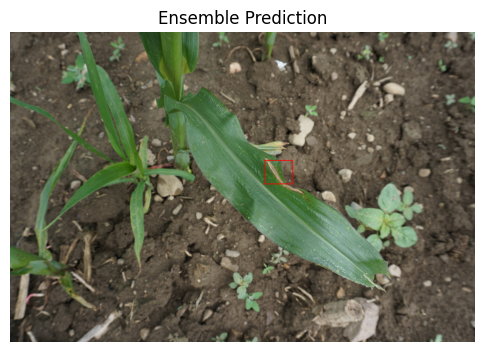

Ground truth boxes for DSC00028.jpg: [[0.385, 0.5413333333333333, 0.512, 0.5953333333333334], [0.479, 0.574, 0.529, 0.642]]


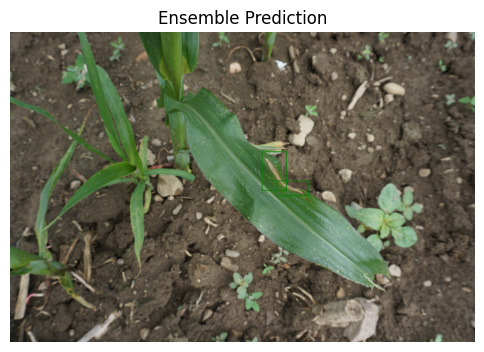

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted 2 boxes for DSC00108.jpg
Boxes: [[0.4402825  0.39129764 0.56823254 0.43352777]
 [0.42716506 0.35918638 0.5586221  0.41005507]]


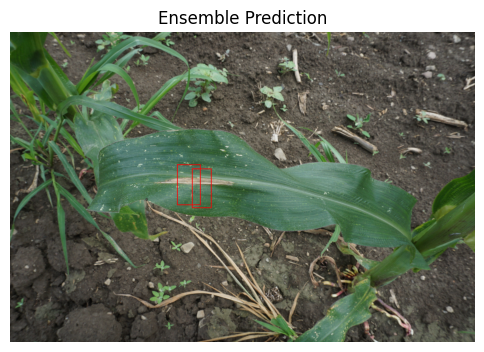

Ground truth boxes for DSC00108.jpg: [[0.476, 0.2866666666666667, 0.49, 0.5093333333333333]]


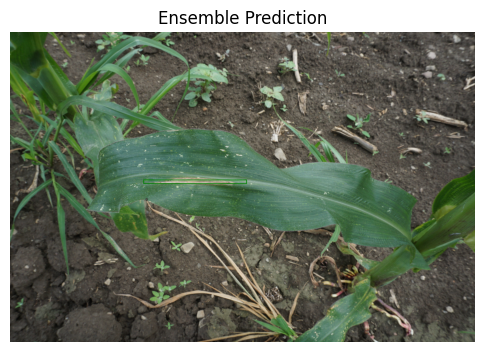

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted 3 boxes for DSC00125.jpg
Boxes: [[0.8670187  0.7591446  0.93141997 0.7849428 ]
 [0.6779795  0.36799455 0.7320381  0.41193783]
 [0.69640964 0.39324415 0.7415746  0.42178184]]


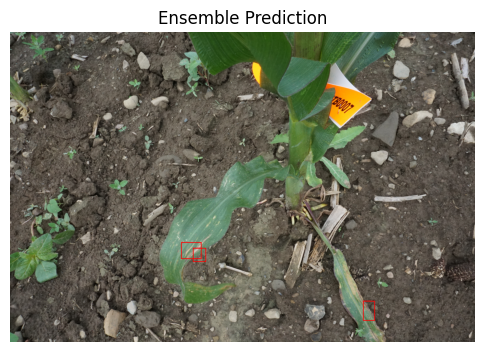

Ground truth boxes for DSC00125.jpg: [[0.65, 0.37066666666666664, 0.75, 0.43533333333333335]]


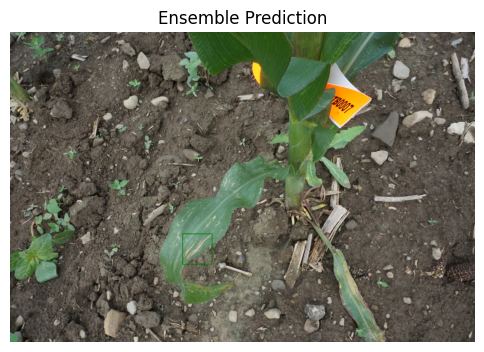

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted 9 boxes for DSC00131.jpg
Boxes: [[0.6053543  0.28382456 0.74758995 0.4132979 ]
 [0.6310174  0.4420446  0.6843006  0.48527172]
 [0.29277977 0.36848626 0.36709246 0.40170845]
 [0.66658616 0.87999237 0.69962335 0.9230205 ]
 [0.80708265 0.0685757  0.85813594 0.11819156]
 [0.7317047  0.08162251 0.7841666  0.12229359]
 [0.83741945 0.8211728  0.889631   0.8548848 ]
 [0.28875336 0.41865003 0.33710936 0.45085728]
 [0.4289326  0.32978308 0.489152   0.39394873]]


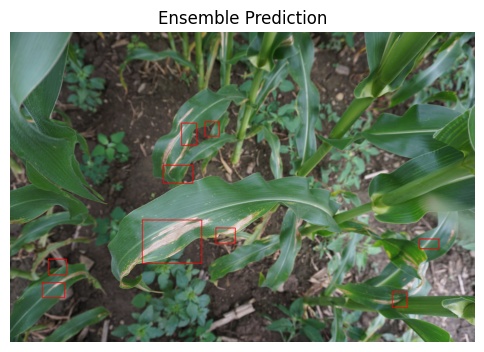

Ground truth boxes for DSC00131.jpg: [[0.237, 0.35133333333333333, 0.312, 0.3973333333333333], [0.299, 0.3253333333333333, 0.42, 0.37733333333333335], [0.377, 0.33066666666666666, 0.457, 0.33666666666666667], [0.338, 0.362, 0.424, 0.38466666666666666], [0.389, 0.342, 0.452, 0.372], [0.586, 0.30333333333333334, 0.668, 0.4126666666666667], [0.58, 0.452, 0.666, 0.5306666666666666], [0.595, 0.61, 0.711, 0.622], [0.726, 0.8353333333333334, 0.765, 0.8766666666666667], [0.772, 0.088, 0.825, 0.148], [0.775, 0.12466666666666666, 0.777, 0.17133333333333334], [0.374, 0.574, 0.448, 0.5793333333333334], [0.144, 0.5306666666666666, 0.206, 0.5473333333333333], [0.591, 0.31133333333333335, 0.687, 0.446], [0.697, 0.23666666666666666, 0.799, 0.3], [0.67, 0.2846666666666667, 0.711, 0.3373333333333333], [0.618, 0.9426666666666667, 0.679, 0.9613333333333334], [0.858, 0.8073333333333333, 0.878, 0.842], [0.862, 0.7733333333333333, 0.875, 0.8313333333333334], [0.818, 0.8586666666666667, 0.847, 0.892], [0.741,

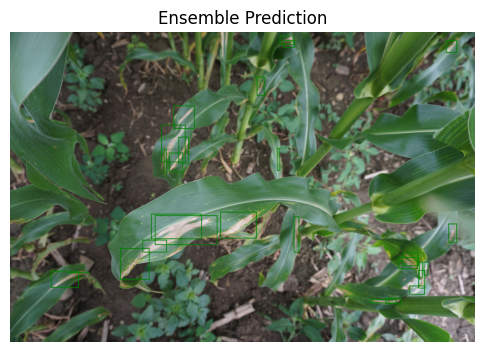

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted 3 boxes for DSC00139.jpg
Boxes: [[0.01511095 0.2919147  0.06019947 0.33401668]
 [0.21407942 0.00429101 0.26129234 0.04962217]
 [0.74550045 0.5233302  0.7907618  0.55694234]]


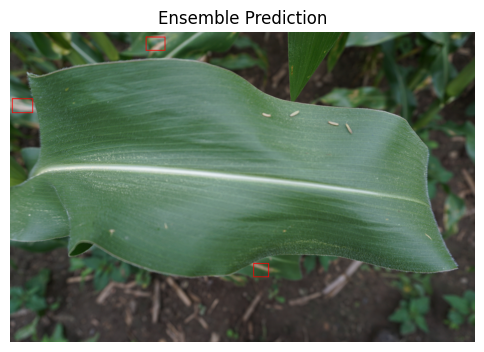

Ground truth boxes for DSC00139.jpg: [[0.007, 0.2986666666666667, 0.02, 0.342], [0.74, 0.5066666666666667, 0.778, 0.576], [0.018, 0.298, 0.073, 0.3446666666666667]]


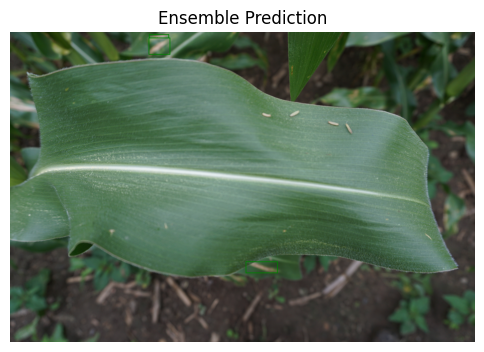

mAP@0.5: 0.06666666644444444


In [ ]:
# Test one Model 
all_pred_boxes = []
all_gt_boxes = []
for i, path in enumerate(image_paths):
    img = Image.open(path).convert("RGB")
    img_resized = img.resize((640, 640))
    img_array = np.array(img_resized) / 255.0

    pred = model_g5.predict(np.expand_dims(img_array, axis=0))[0]
    final_boxes, final_scores = apply_nms(pred, conf_thresh=0.3, iou_thresh=0.5)
    #print(f"Predicted {len(final_boxes)} boxes for {os.path.basename(path)}")
    #print("Boxes:", final_boxes)
    #draw_ensemble_boxes_on_image(img, final_boxes, color="red", label="Model G5")

    fname = os.path.basename(path)
    gt_boxes = gt_boxes_list[i]
    #print(f"Ground truth boxes for {fname}: {gt_boxes}")
    #draw_ensemble_boxes_on_image(img, gt_boxes, color="green", label="Ground Truth")

    all_pred_boxes.append(final_boxes)
    all_gt_boxes.append(gt_boxes)

mAP = mean_average_precision(all_pred_boxes, all_gt_boxes, iou_threshold=0.5)
print("mAP@0.5:", mAP)

In [107]:
test_ds = load_test_dataset_from_tfrecord(r"C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\M-AI-ZE-Maize-diseases-detection\data\test_dataset_10.tfrecord")

In [108]:
test_set_path = r'C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\My-Testset'

In [ ]:
num_images = 20 
image_paths = image_paths[:num_images]


#Test ensemble of three models
all_pred_boxes = []
all_gt_boxes = []
for i, path in image_paths:
    img = Image.open(path).convert("RGB")
    img_resized = img.resize((640, 640))
    img_array = np.array(img_resized) / 255.0

    # Use ensemble of three models instead of single model
    models = [model_g20, model_g10, model_g5]
    final_boxes, final_scores = ensemble_three_models_on_image(models, img_array)

    fname = os.path.basename(path)
    gt_boxes = gt_boxes_list[i]

    all_pred_boxes.append(final_boxes)
    all_gt_boxes.append(gt_boxes)

mAP = mean_average_precision(all_pred_boxes, all_gt_boxes, iou_threshold=0.5)
print("mAP@0.5:", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/

In [110]:
image_batch, original_images, image_paths = load_images_from_folder(test_set_path, num_images=5)

Loaded 5 image(s) from: C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\My-Testset


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


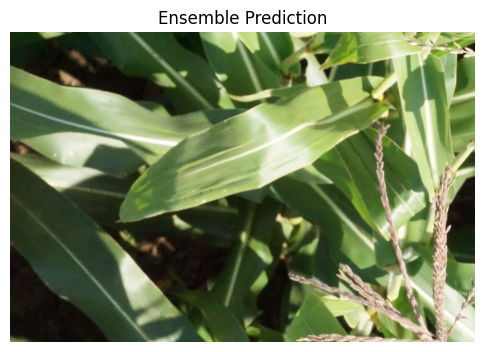

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


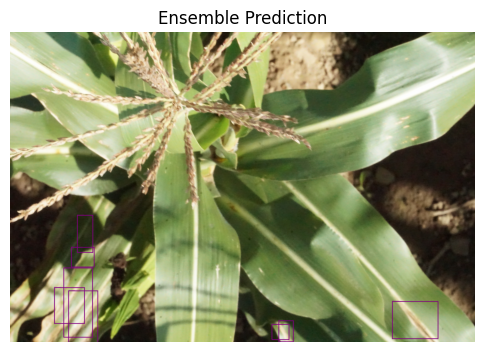

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


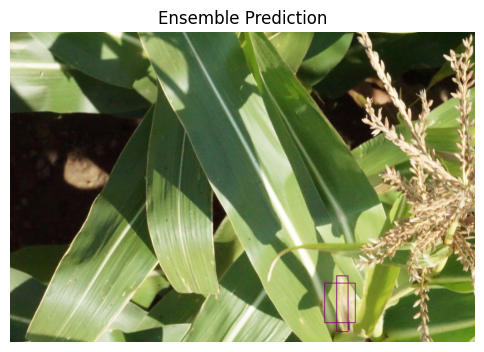

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


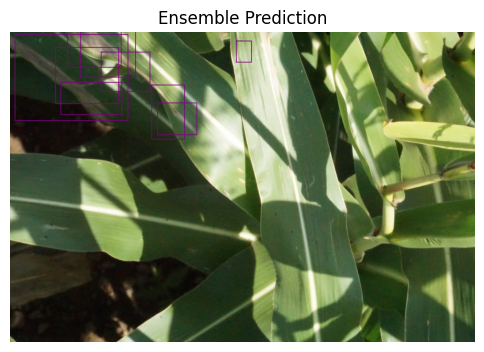

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


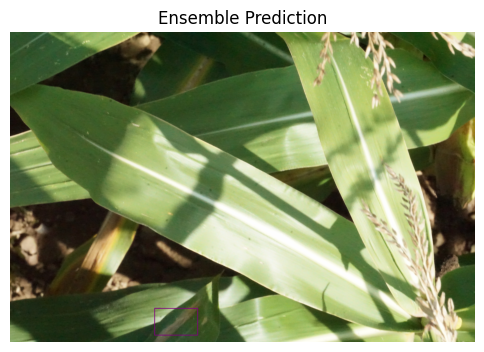

In [111]:
for i in range(len(image_batch)):
    models = [model_g20, model_g10, model_g5]
    final_boxes, final_scores = ensemble_three_models_on_image(models, image_batch[i])
    draw_ensemble_boxes_on_image(original_images[i], final_boxes, color="purple", label="Ensemble")
